# Case Study 1: From Exploration to Design

- Name: Luke Clausi
- Student ID: 52447760
- Link to GitHub Repository: https://github.com/lukeclausi/dsci-200-case-study-1

This blank notebook is provided for you to use to answer questions from [Case Study 1](https://ubc-dsci.github.io/dsci-200/case-studies/case-study-1.html). 

In [1]:
#install.packages("tidyverse")
#install.packages("devtools")
#devtools::install_github("lbelzile/hecedsm")

In [2]:
library(tidyverse)
library(hecedsm)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘hecedsm’


The following object is masked from ‘package:stringr’:

    words




In [11]:
dat <- BRLS21_EDA    
head(dat)           

id reltime task     occurence eda      hr      
1 1  0       baseline 1         20.60959 88.49560
2 1  1       baseline 1         21.41062 88.31564
3 1  2       baseline 1         22.26244 78.13892
4 1  3       baseline 1         24.22100 65.82009
5 1  4       baseline 1         24.23851 65.13290
6 1  5       baseline 1         23.63703 66.83456

The study investigates how different notification and communication methods affect driver distraction and performance. The primary objective is to compare the distraction caused by receiving and responding to messages using a smartwatch versus a mobile phone, and to evaluate whether a voice-based assistant (speaker) reduces distraction compared to screen based notifications. The authors also investigate differences of the effects between inbound text vs inbound voice messages and between outbound voice replies vs outbound text replies.

These goals are important because wearable devices are becoming increasingly common, and distraction while driving is a major safety concern. While mobile phone use is generally restricted by law, smartwatch use is less explicitly regulated, so understanding its distraction potential has direct implications for traffic safety guidance and device design.

The study hypothesizes that smartwatch notifications will be more distracting than phone notifications (vision less focused on the driving task), that speaker/voice assistant delivery will be less distracting than phone delivery, and that texting-based responding will be most distracting and degrade driving performance.

*Note - The BRLS21_EDA dataset contains smartwatch-recorded physiological measures (EDA and heart rate) collected during the experiment. These measures are related to the study context but were not the primary outcomes analyzed in the published paper.* 

In [4]:
head(dat)     # check data 
dim(dat)      # data dimensions check

id reltime task     occurence eda      hr      
1 1  0       baseline 1         20.60959 88.49560
2 1  1       baseline 1         21.41062 88.31564
3 1  2       baseline 1         22.26244 78.13892
4 1  3       baseline 1         24.22100 65.82009
5 1  4       baseline 1         24.23851 65.13290
6 1  5       baseline 1         23.63703 66.83456

[1] 10942     6

(3, 4, 5) We observe there are 6 variables and 10942 observations in the data. 

Categorical Variables: 
- id (factor) -> identifier for participants
- task (factor) condition label (baseline, distraction subtypes including voicecall/watch)

Numerical: 
- reltime (integer) -> time index
- occurence (integer) -> occurence count
- eda (double) -> electrodermal activity
- hr (double) -> heart rate

No major conversion is needed here as id and task are already stored as factors and the physiological measurements are numeric. 

In [5]:
colSums(is.na(dat))
colMeans(is.na(dat))

task_count <- dat %>%
    count(task) %>%
    mutate(prop = n / sum(n)) 
task_count

id   reltime      task occurence       eda        hr 
        0         0         0         0       214       538

id    reltime       task  occurence        eda         hr 
0.00000000 0.00000000 0.00000000 0.00000000 0.01955767 0.04916834

task      n    prop     
1 baseline  2736 0.2500457
2 cell      3028 0.2767319
3 voicecall 1392 0.1272162
4 watch     3786 0.3460062

(6, 7) Missing values were assessed for each variable. EDA has 214 missing values (1.96%) and hr has 538 missing values (4.92%), while id, reltime, task, and occurence all have no missing values. No variable exceeds a 20% missingness threshold, so missing data are unlikely to dominate the analysis. However, we should still use na.rm = TRUE to handle missingness while working with hr or eda. 

The proportion of tasks is as follows: 34.6% watch, 27.7% cell, 25.0% baseline, and 12.7% voicecall. To check for task imbalance, we consider if these classes are severely skewed, and we note that there is no unacceptable imbalance that would be likely to dominate the dataset, but we should also note that voicecall is noticeably smaller than other conditions and could lead to less stable estimates. Overall, the largest group (watch) is 2.7x the smallest (voicecall), so there is some imbalance but no extreme majority-class situation.

(9) Below is a visualization of the distribution of the electrodermal activity variable - a histogram was used to view the distribution of a single numerical variable. We observe a right-skewed, relatively bell-shaped curve. Most observations fall between 5 and 15, there is a main peak around 8-12, and the tail on the right suggests potential spikes in stress during the participants recorded data points, reaching much higher levels of EDA. 

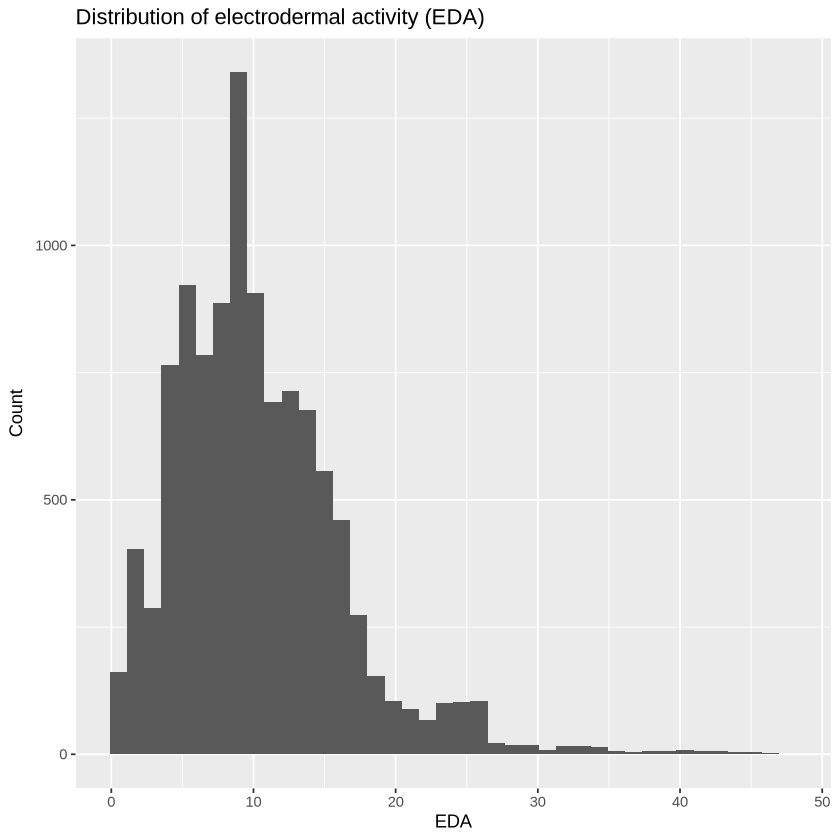

In [6]:
eda_dist_graph <- 
    ggplot(dat, aes(x = eda)) +
    geom_histogram(bins = 40, na.rm = TRUE) +
    labs(
      title = "Distribution of electrodermal activity (EDA)",
      x = "EDA",
      y = "Count")

eda_dist_graph

(10) Below is a visualization of the relationship between a categorical variable (task) and a numerical variable (eda). The plot used is a jittered scatter plot, which is appropriate for comparing the distribution of a numerical variable across multiple categories (in our case, the categorical task). We note that EDA clearly varies by task, with baseline having the lowest mean EDA, and the least high-ended outliers. Meanwhile, the three non-baselines distractions all have some spiked values in EDA as well as a broader spread, with voicecall especially having significant high-EDA results. This suggests that the baseline observations were less emotionally active / stressed than the distracted observations, and that the voicecall task had some participants respond as extreme outliers in their EDA measuring.  

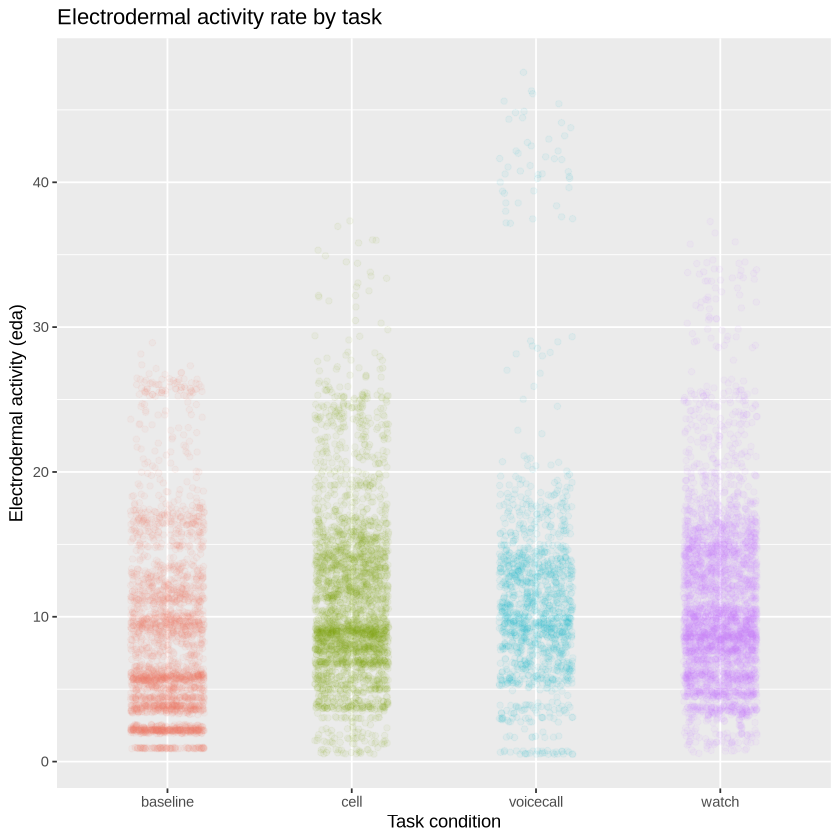

In [7]:
eda_task_graph <-
    ggplot(dat, aes(x = task, y = eda, color = task)) +
    geom_jitter(alpha = 0.05, width = 0.2, na.rm = TRUE) +
    guides(color = "none") +
    labs(
      title = "Electrodermal activity rate by task",
      x = "Task condition",
      y = "Electrodermal activity (eda)"
  )

eda_task_graph

(11) Below is a visualization of the distribution of a categorical variable in the dataset - id (participant identifier). The plot is executed as a bar chart, which is appropriate for showing how frequently each category (participant) appears (is observed). We observe that most participants contribute a similar number of observations, with counts generally clustered in the same range, suggesting the dataset is fairly balanced across participants. There are a few participants with noticeably fewer or more observations, which could reflect differences in recording length, missingness, or task completion. A typical value for this distribution is therefore a participant with about the common bar height shared by most ids, in the range of 300-400 observations. No single ID overwhelmingly makes up the dataset. 

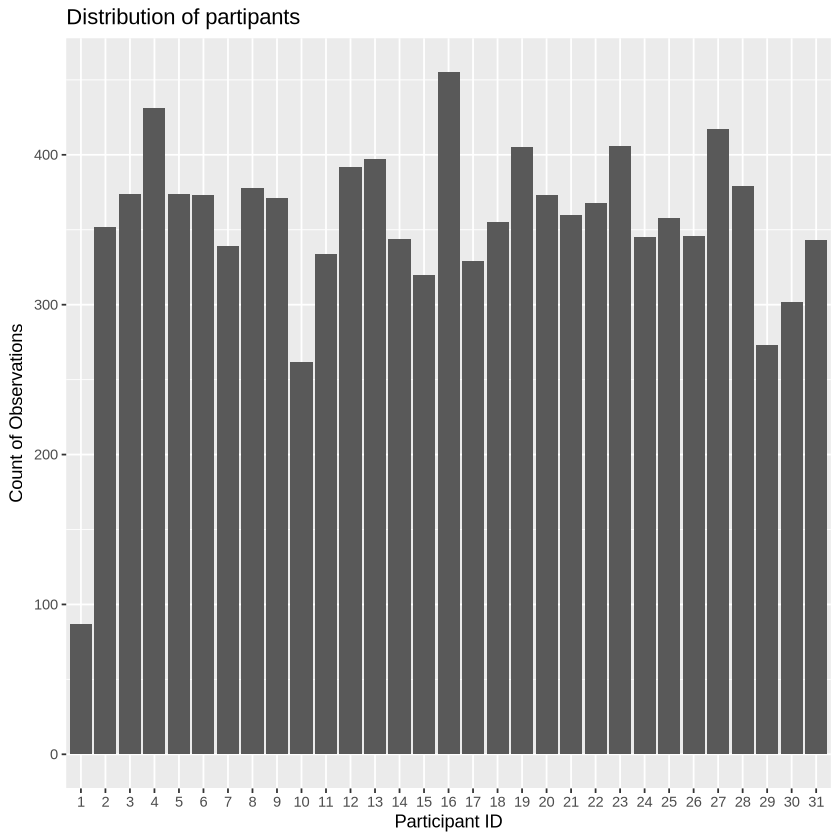

In [8]:
ggplot(dat, aes(x = id)) +
  geom_bar() +
  labs(
    title = "Distribution of partipants",
    x = "Participant ID",
    y = "Count of Observations"
  )

In [9]:
dat %>%   # tendencies of EDA variable 
  summarise(
    mean_eda = mean(eda, na.rm = TRUE),
    median_eda = median(eda, na.rm = TRUE),
    sd_eda = sd(eda, na.rm = TRUE),
    IQR_eda = IQR(eda, na.rm = TRUE)
  )

dat %>%   # correlation between hr and eda
  summarise(cor_hr_eda = cor(hr, eda, use = "complete.obs"))

mean_eda median_eda sd_eda   IQR_eda 
1 10.39493 9.366185   6.007639 7.374645

cor_hr_eda
1 0.1435454

(12, 14) In the data, the electrodermal activity (EDA) is a numerical variable. An appropriate measure of its central tendency is its median, as the values were observed to be right-skewed, and the median is robust to those extreme values. The median EDA is 9.37, which suggests the mean is pulled upwards by higher-end values. The mean is notably higher than the median (10.39), reinforcing our observation of the right-skewed distribution. The spread is also substantial (interquartile range of 7.37, standard deviation of 6.01).

Heart rate and electrodermal activity are both numerical variables in the dataset. I computed the pearson correlation to summarize the linear relationship between these variables, dropping any incomplete observations, resulting in a correlation of  0.1435. This value indicates a weak positive relationship, meaning higher heart rates tend to be slightly associated with higher EDA, but not strongly. 

(15, 16, 17) 
A research question I would like to answer with this data would be: How does electrodermal activity (EDA) change over time during each task condition (baselines, cell, voicecall, watch)? Do some task conditions show faster increases in EDA or other changes over time compared to baseline? This question stems from the visualization of EDA by task in task 3, where it was noted that the distributions of EDA observations were different across tasks, being notably higher outside of the baseline. 

I would not split the data into train and test, because this is an inferential question about patterns over time across experimental conditions, not a prediction task. Splitting would be appropriate if the task was to build a model to predict EDA for new unseen observations as opposed to just observing the patterns available in the data. 

To help answer this question, I created a new feature called eda_centered, defined as each observation's EDA minus that particpant's average EDA across the experiment. This transformation adjusts for between-person differences (higher or lower natural EDA levels of each participant), making it easier to compare how task conditions shift the state within the same person. This is useful for answering how task and reltime relate to EDA changing over time within individual participants and discerning any trends in this regard. 

In [10]:
dat_updated <- dat %>%
  group_by(id) %>%
  mutate(
    eda_centered = eda - mean(eda, na.rm = TRUE)) %>%
  ungroup()

head(dat_updated)

id reltime task     occurence eda      hr       eda_centered
1 1  0       baseline 1         20.60959 88.49560 -0.03173011 
2 1  1       baseline 1         21.41062 88.31564  0.76929989 
3 1  2       baseline 1         22.26244 78.13892  1.62111989 
4 1  3       baseline 1         24.22100 65.82009  3.57967989 
5 1  4       baseline 1         24.23851 65.13290  3.59718989 
6 1  5       baseline 1         23.63703 66.83456  2.99570989

(18, 19, 20) The authors of the paper are primarily asking causal and inferential questions - they manipulate the condition of the notification/interaction (phone, watch, voice, baseline), and compare how distraction and driving outcomes differ across conditions. Because the conditions are assigned within the same participants, they're aiming to draw conclusions about how the type of device/interaction impacts distraction and performance, specifically comparing the smartwatch with phone usage and a baseline. 

The population of interest includes drivers or potential drivers who might receive and respond to notifications using handhold technologies while driving. The observed sample was 31 participants who completed tasks in a driving simulation as part of an experiment conducted at Tech3Lab, HEC Montreal.

This was a controlled experiment sudy, specifically a within-subject, repeated measures expreiment. The researchers manipulated the independent variable, the type of distraction for the drivers, in order to measure the outomes of their heartrate and eletrodermal activity, while "driving" in a simulator. Each participant experiences multiple conditions, so the individual differences are partially controlled by the design of the experiment itself. 

(21, 23) The researchers partially controlled confounding variables through the experiment design - they used a within-subject driving simulator experiment, repeatedly measuring the same participants throughout different task conditions (phone, voice, watch, baseline). This design helps control for person to person differences (baseline stress level and heart rate, general driving confidence, etc), letting each person serve as their own comparison. They also used a driving simulator which has standardized conditions, elimination real-world variance in conditions, events, and environment. 

It is likely there is some sampling bias in this experiment. This is because it was done by 31 participants in a lab driving simulator, creating possible limits and biases. People willing and available to do a simulator study do not necessarily represent the broader driving population. The sample size is somewhat small, with only 31 participants, meaning the estimated results could be unstable and fail to generalize to the population. The simulator itself may produce different results that real world driving to an extent, given behaviour and stress may be different as some participants could be less stressed in the simulator, and be less distracted by the phone/watch by extension (as they know they are not putting anyone at risk by being distracted, and thus their heart rate and EDA may not spike as it would in a real-world driving situation).

(24) If I were to design this experiment myself, I would keep the within-subject experiment design, as it is a strong way to control for stable person to person differences in EDA, heart rate, and driving ability/confidence. However, I would modify the sampling approach and add a few design elements to improve generalizability and reduce any potential sources of bias. 

I would aim for a larger sample, as diversified as possible while remanining accurate to the driving population. This would reduce the risk of the findings reflecting only a narrow group of volunteers. As well, I would recruit participants with varying levels of smartphone and smartwatch use. This would allow me to collect self-reported, real world behaviour data by asking participants how often they use phone, smartwatch, or voice assistants while driving. This allows me to examine whether habitual device use moderates the effects in the experiment (ex, if those who use the phone more while driving do not show signs of stress while using the phone while driving). This variable allows us to help interpret new aspects of the results and could be used to adjust for differences in baseline behaviour across participants. 

The authors likely did not use these alternative approaches as they are costly in time and logistics. Recruiting a larger sample and thus running more sessions is a direct time requirement. My approach of using self-reported behaviour data requires a large enough sample to cut into categorical chunks, and thus also was beyond the scope of the authors 31-person study. The self-reported device information may  be quite noisy or biased, but with a large enough sample could provide useful context and an additional related variable to draw conclusions around. I also acknowledge that, while the simulator may result in different user behaviour and observations than real-world driving, it is a massive logistical hurdle to close this gap. It is unrealistic to collect data of real-world experiences in this case (as it makes no sense to send driver into public roads and make them use a smartphone/watch while driving, and is almost certainly illegal), and the only alternative would be a well-designed private track, which is logistically and financially difficult, and not guaranteed to produce real-world results either. 